Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

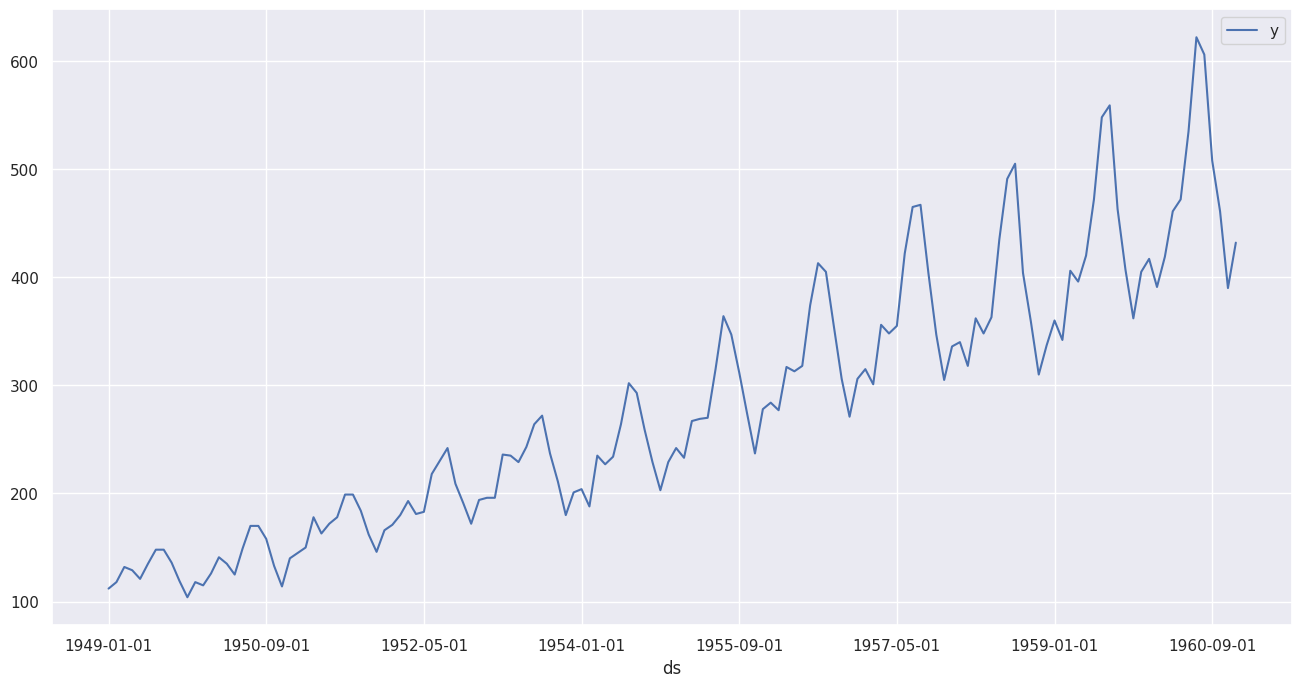

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **SYBIL Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Default model request
model_request = {
    'type': 'meta_lr',  # 'meta_wa'
    'scorers': ['smape', 'mape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer', 'params': {'strategy': 'mean'}},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_rnn'},
            {'type': 'darts_lightgbm'},
            {'type': 'darts_autotheta'},
            {'type': 'darts_autoarima'},
            {'type': 'darts_autoets'},
            # {'type': 'stats_autotheta'},
            # {'type': 'stats_autoarima'},
            # {'type': 'stats_autoets'},
        ],
    },
}

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'params': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['sybil_protocol']
host = url_dict['sybil_host']
port = url_dict['sybil_port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 9.71 s


In [22]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCC3FAQAoxQEASzABABgAAABCMAEANCgAAD+AAGVsaZOMb5Rsb4xtlARhaZRNYYFpYWlhjIwuYQtlgR9hbIxylBcuZmmUR5Qoc250bWRvdIxsaWRnaXJhZYxygR90lIx4b2FEeX1vaGF2lFaUlHNfeG94YWVwgWFwb3h0Xx9lZQ1llHRkc5RfZXmTYWFhlGmUTnV0AlKU/31LhnVlch9ydYx5Qyhfh2P/fUuGBKgsxUl+Aje7P3X5LrI2zlKIDB9BxUl/Azi8QNhckhZLz1OIDELGSjG16m6jJ6vhZZoeoh86vvR4rTG162+kKKxEyP6Ctzu/9HiuMrZO0geLwUXJ/h+CuDzApipg5BmdIVfbEJQYsDRq7iOnK2DkGp4iuj509x8tsTVq7iSoLMRIfQE3uz90+C6yNhyg1lqPE5fNUYaUlB9uhnSGdGWUCW5OhZQYY2VlX5RlaIUoX4cB/0uMaJQxKB9LYmh1ZWQoci6Uc5SMaFRVYpRLiRanS9wer/GCE1XmKB+5Su5/wVKUJbb4ictc7ZEiZPU3yFmbLG7/kIMUVucpuh9LjR5g8YImt/mKzF3uMMEDlCXJWpwtbwCR02SmN8hs/R8/0BKjNHYHSdprXu8xwgSVJmj5O8xdAZLUZac4yQuc3h9vAKQ1dwhK22yuP4ESo0fYGqvtfg9R4iS1RjnKDJ3fcB8BQ9QWlBtfbHNvbpRjX3M3ZGN5lJSRaGgBXWiUpV8JbA1hkygGh0tSAQJSTv9iAOCGAB90jF90aZSUX2RfZWTBX1Nfb5R0bGWMb19OZWFlF192lB9zb3NwdXKMZm9zbnNvc3B0coxzb3N0lGVzZYxkKWdhXx90YXJpE2NuDG8ujG2MYWGIb2FyjHJ0YU5vdHaUTmVycBNuZWRlbJQoYmh0iXN1X0sBaWwVYWBOD04Obl10ZZNohwB0lHRvjGWgCh9zZoxlb2JobExlKWJfZ2KUbB9l/25lmXNzY

### **SYBIL Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [23]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [24]:
model = train_json_out['model']

Forecast API JSON Payload

In [25]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [26]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [27]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 26 ms, sys: 0 ns, total: 26 ms
Wall time: 283 ms


In [28]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1960-12-31T00:00:00', 420.4216160478973],
  ['1961-01-30T00:00:00', 398.0844437237083],
  ['1961-03-01T00:00:00', 447.65902213215526],
  ['1961-03-31T00:00:00', 470.8748350823534],
  ['1961-04-30T00:00:00', 484.0539751669631],
  ['1961-05-30T00:00:00', 565.2277983302522],
  ['1961-06-29T00:00:00', 652.1267840956648],
  ['1961-07-29T00:00:00', 645.6961694311494],
  ['1961-08-28T00:00:00', 543.0927458849617],
  ['1961-09-27T00:00:00', 478.8926523043909],
  ['1961-10-27T00:00:00', 400.25726543091184],
  ['1961-11-26T00:00:00', 457.942240982859],
  ['1961-12-26T00:00:00', 470.47103535340074],
  ['1962-01-25T00:00:00', 447.19418575458593],
  ['1962-02-24T00:00:00', 501.139054714192],
  ['1962-03-26T00:00:00', 523.2437089204948],
  ['1962-04-25T00:00:00', 536.6160759114925],
  ['1962-05-25T00:00:00', 622.4305978284358],
  ['1962-06-24T00:00:00', 713.3480375240722],
  ['1962-07-24T00:00:00', 706.6827042158109],
  ['1962-08-23T00:00:00', 598.4488596223541],
  ['1962-09-22T00:00:00'

Combine forecast dates and output

In [29]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [30]:
forecast_df.shape

(24, 2)

In [31]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [32]:
forecast_df.head()

,ds,y
0,1960-12-31T00:00:00,420.421616
1,1961-01-30T00:00:00,398.084444
2,1961-03-01T00:00:00,447.659022
3,1961-03-31T00:00:00,470.874835
4,1961-04-30T00:00:00,484.053975


In [33]:
forecast_df.tail()

,ds,y
19,1962-07-24T00:00:00,706.682704
20,1962-08-23T00:00:00,598.448860
21,1962-09-22T00:00:00,529.348888
22,1962-10-22T00:00:00,446.454852
23,1962-11-21T00:00:00,507.588502


### **MAUQ Quantify Uncertainty API**

In [34]:
forecast_output = forecast_json_out['data']

In [35]:
forecast_output

[['1960-12-31T00:00:00', 420.4216160478973],
 ['1961-01-30T00:00:00', 398.0844437237083],
 ['1961-03-01T00:00:00', 447.65902213215526],
 ['1961-03-31T00:00:00', 470.8748350823534],
 ['1961-04-30T00:00:00', 484.0539751669631],
 ['1961-05-30T00:00:00', 565.2277983302522],
 ['1961-06-29T00:00:00', 652.1267840956648],
 ['1961-07-29T00:00:00', 645.6961694311494],
 ['1961-08-28T00:00:00', 543.0927458849617],
 ['1961-09-27T00:00:00', 478.8926523043909],
 ['1961-10-27T00:00:00', 400.25726543091184],
 ['1961-11-26T00:00:00', 457.942240982859],
 ['1961-12-26T00:00:00', 470.47103535340074],
 ['1962-01-25T00:00:00', 447.19418575458593],
 ['1962-02-24T00:00:00', 501.139054714192],
 ['1962-03-26T00:00:00', 523.2437089204948],
 ['1962-04-25T00:00:00', 536.6160759114925],
 ['1962-05-25T00:00:00', 622.4305978284358],
 ['1962-06-24T00:00:00', 713.3480375240722],
 ['1962-07-24T00:00:00', 706.6827042158109],
 ['1962-08-23T00:00:00', 598.4488596223541],
 ['1962-09-22T00:00:00', 529.3488878544756],
 ['1962-

Quantify Uncertainty API JSON Payload

In [36]:
user_value = 10
api_json = {
    'forecast_output': forecast_output,
    'value': user_value
}

Build URL (same as train except for the endpoint)

In [37]:
# URL to our MAUQ AWS service
protocol = url_dict['protocol']  # protocol not sybil_protocol
host = url_dict['host']
port = url_dict['port']
endpoint = 'quantify-uncertainty'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [38]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 3.55 ms, sys: 0 ns, total: 3.55 ms
Wall time: 9.62 ms


In [39]:
uncertainty_json_out = response.json()  # dict output
# uncertainty_json_out

In [40]:
uncertainty_output = uncertainty_json_out['data']
# uncertainty_output

Combine forecast dates and output

In [41]:
# uncertainty_json_out['data']

In [42]:
uncertainty_df = pd.DataFrame(
    data=uncertainty_json_out['data'],
    columns=[time_col, target_col, 'lower_interval', 'higher_interval'],
)

In [43]:
uncertainty_df.shape

(24, 4)

In [44]:
uncertainty_df.columns

Index(['ds', 'y', 'lower_interval', 'higher_interval'], dtype='object')

In [45]:
uncertainty_df.head()

,ds,y,lower_interval,higher_interval
0,1960-12-31T00:00:00,420.421616,410.421616,430.421616
1,1961-01-30T00:00:00,398.084444,388.084444,408.084444
2,1961-03-01T00:00:00,447.659022,437.659022,457.659022
3,1961-03-31T00:00:00,470.874835,460.874835,480.874835
4,1961-04-30T00:00:00,484.053975,474.053975,494.053975


In [46]:
uncertainty_df.tail()

,ds,y,lower_interval,higher_interval
19,1962-07-24T00:00:00,706.682704,696.682704,716.682704
20,1962-08-23T00:00:00,598.448860,588.448860,608.448860
21,1962-09-22T00:00:00,529.348888,519.348888,539.348888
22,1962-10-22T00:00:00,446.454852,436.454852,456.454852
23,1962-11-21T00:00:00,507.588502,497.588502,517.588502


Plot train and forecast side-by-side

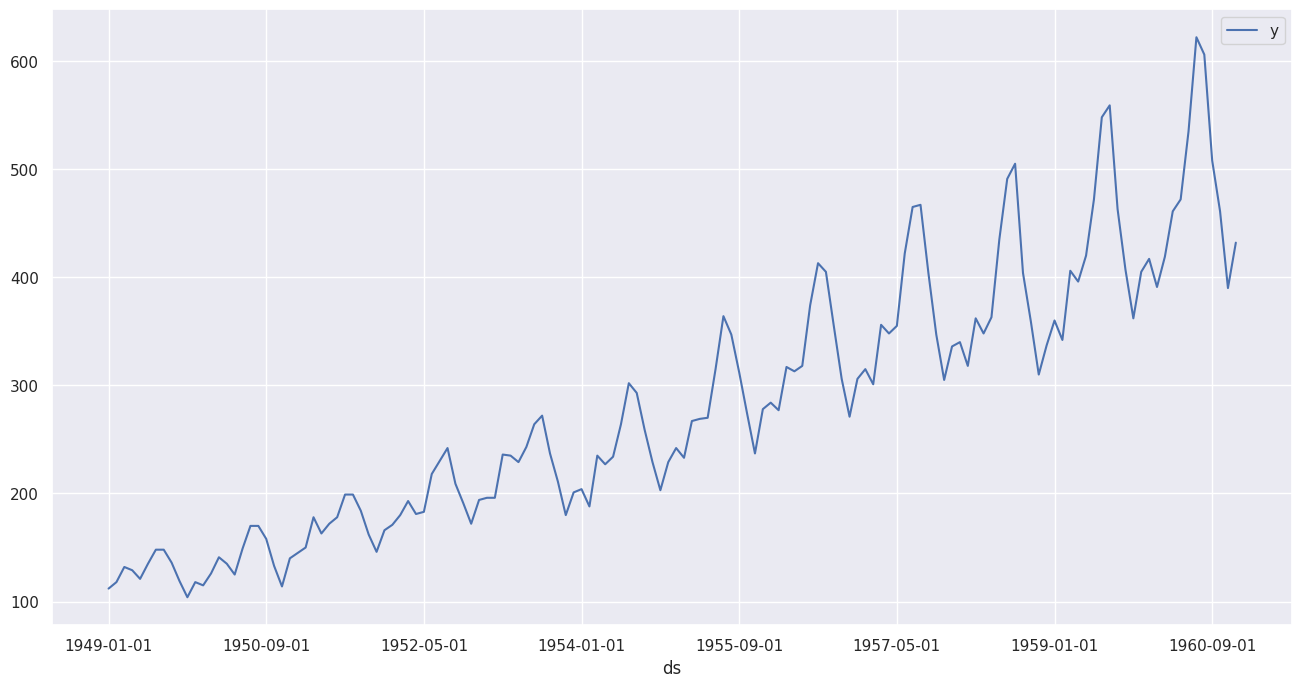

In [47]:
# Train
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

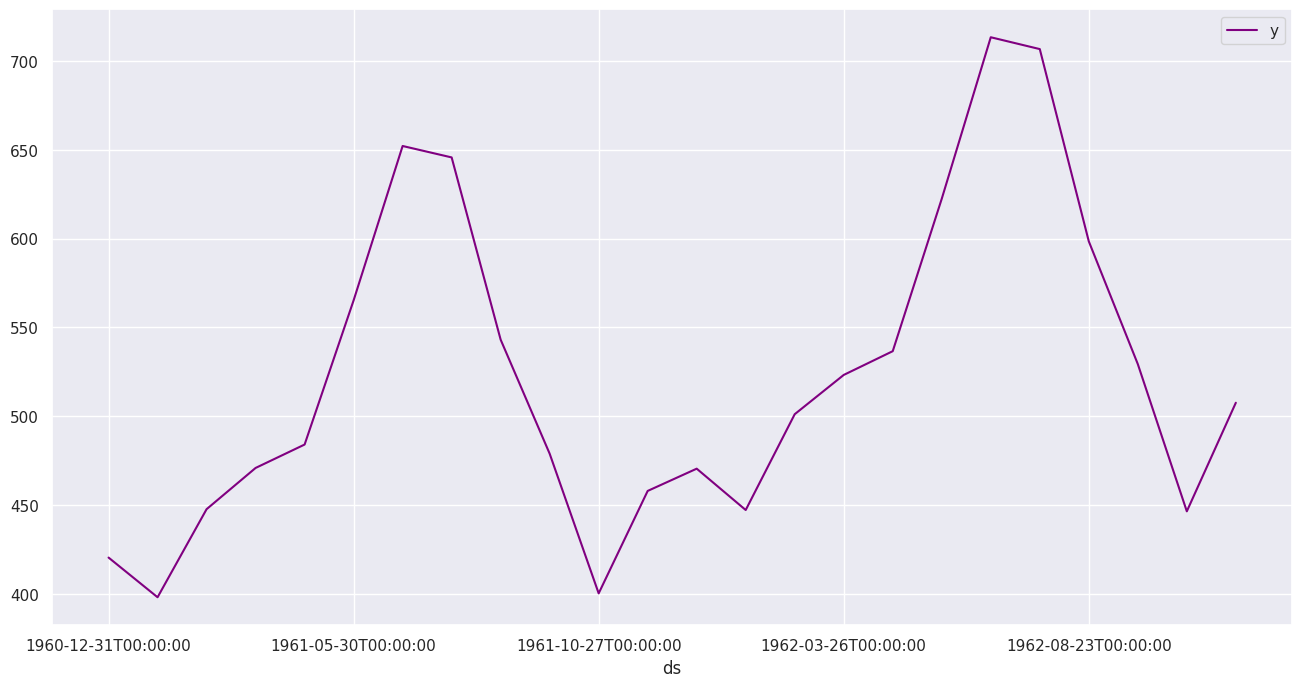

In [48]:
# Forecast
forecast_df['color'] = 'purple'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

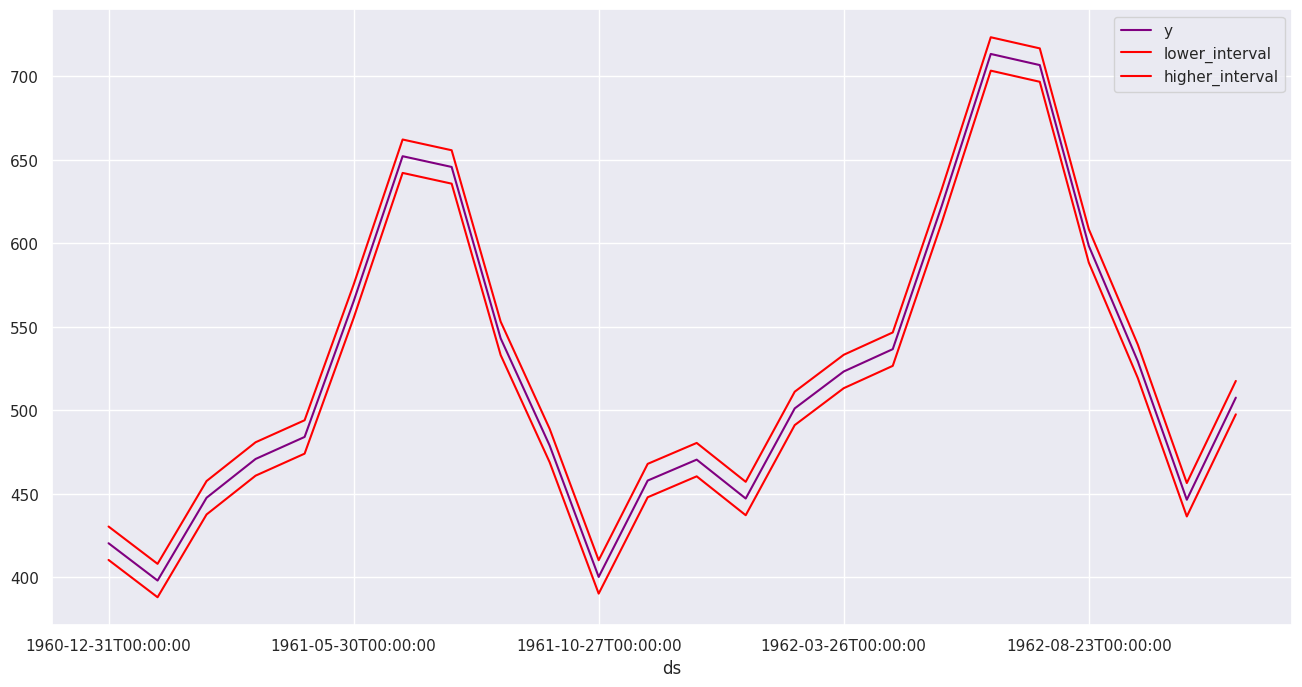

In [49]:
# Probabilistic Forecast (with MAUQ)
uncertainty_colors = ['purple', 'red', 'red']
uncertainty_df.set_index(time_col).plot(figsize=figsize, color=uncertainty_colors);

Combine train and forecast sets

In [50]:
train_df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [51]:
forecast_df.head()

,ds,y,color
0,1960-12-31T00:00:00,420.421616,purple
1,1961-01-30T00:00:00,398.084444,purple
2,1961-03-01T00:00:00,447.659022,purple
3,1961-03-31T00:00:00,470.874835,purple
4,1961-04-30T00:00:00,484.053975,purple


In [52]:
uncertainty_df.head()

,ds,y,lower_interval,higher_interval
0,1960-12-31T00:00:00,420.421616,410.421616,430.421616
1,1961-01-30T00:00:00,398.084444,388.084444,408.084444
2,1961-03-01T00:00:00,447.659022,437.659022,457.659022
3,1961-03-31T00:00:00,470.874835,460.874835,480.874835
4,1961-04-30T00:00:00,484.053975,474.053975,494.053975


In [53]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [54]:
df.shape

(168, 3)

In [55]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [56]:
df.tail()

,ds,y,color
163,1962-07-24T00:00:00,706.682704,purple
164,1962-08-23T00:00:00,598.448860,purple
165,1962-09-22T00:00:00,529.348888,purple
166,1962-10-22T00:00:00,446.454852,purple
167,1962-11-21T00:00:00,507.588502,purple


Plot combined train and forecast sets with the vertical black line as the cut-off

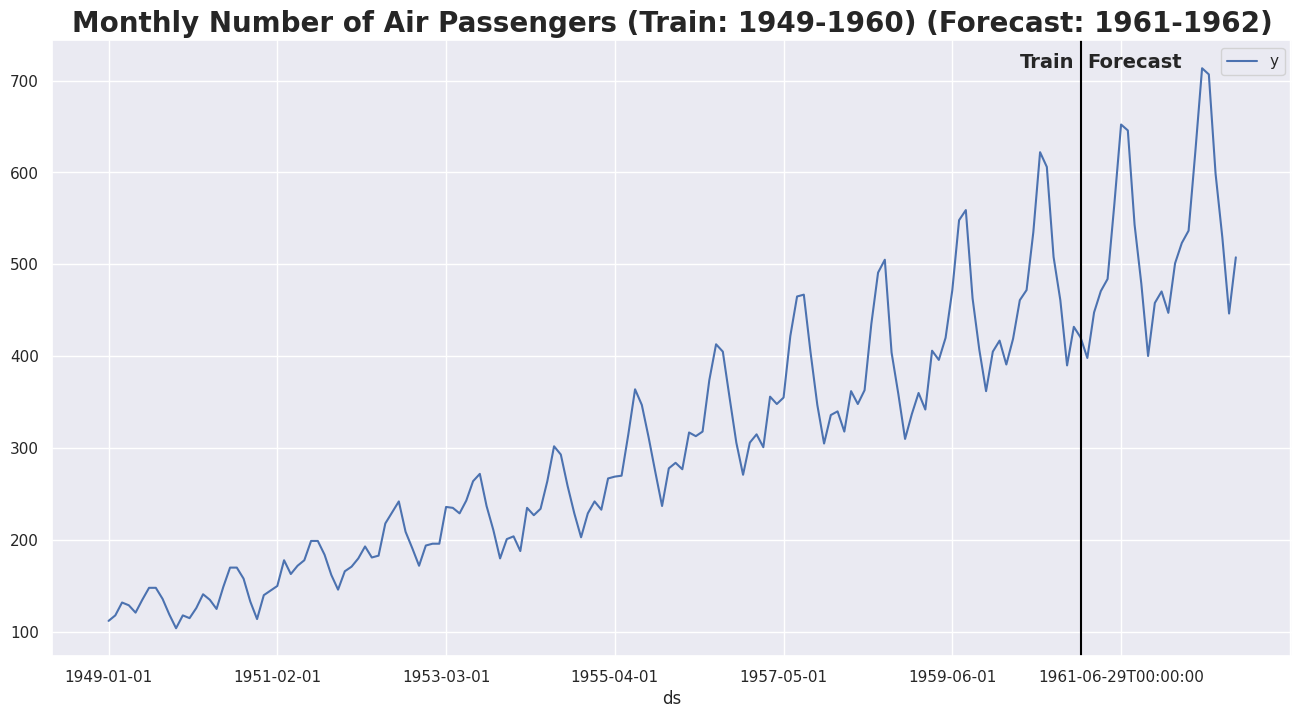

In [57]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();